In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
import cupyx.scipy.ndimage as ndimage
from holotomo.holo import G, GT
from holotomo.magnification import M, MT
from holotomo.shift import S, ST

%matplotlib inline

cp.cuda.Device(0).use()


<CUDA Device 0>

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208 # [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8 # make multiple of 8

## Read data

In [3]:
data00 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref00 = np.zeros([ndist,n,n],dtype='float32')

for k in range(ndist):
    data00[k] = dxchange.read_tiff(f'/data/vnikitin/modeling/data_3d_ald_{n}_{k}.tiff')[:ntheta]
    ref00[k] = dxchange.read_tiff(f'/data/vnikitin/modeling/ref_3d_ald_{n}_{k}.tiff')
shifts_sample = np.load('/data/vnikitin/modeling/shifts_sample.npy')[:ndist,:ntheta]#/norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref = np.load('/data/vnikitin/modeling/shifts_ref.npy')[:ndist,:ntheta]#/norm_magnifications[:,np.newaxis,np.newaxis]
shifts_ref0 = np.load('/data/vnikitin/modeling/shifts_ref0.npy')[:ndist]#/norm_magnifications[:,np.newaxis,np.newaxis]

# Assuming the shifts are known, shift data and refs back and perform reconstruction with the MultiPaganin

In [4]:
data0 = cp.array(data00)
ref0 = cp.array(ref00)
# shifted refs for correction
ref0c = cp.tile(cp.array(ref00[:,cp.newaxis]),(1,ntheta,1,1))

for k in range(ndist):    
    # shift refs back
    pars = {'shift': shifts_ref0[k]}            
    ref0[k] = ST(ref0[k].astype('complex64'), pars).real       
    # shift refs the position where they were when collecting data    
    pars = {'shift': shifts_ref[k]}            
    ref0c[k] = S(ref0[k].astype('complex64'), pars).real       

In [5]:
rdata = data0/ref0c

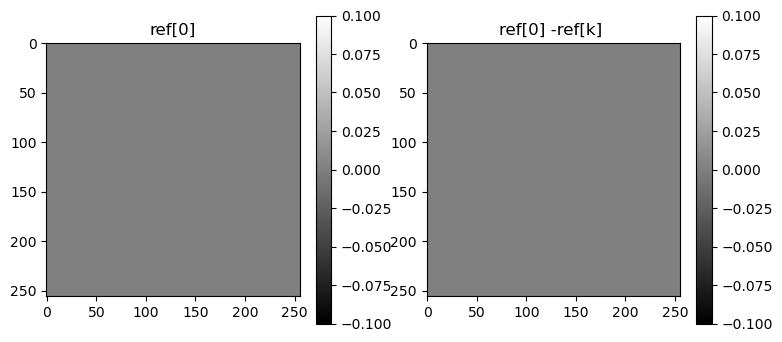

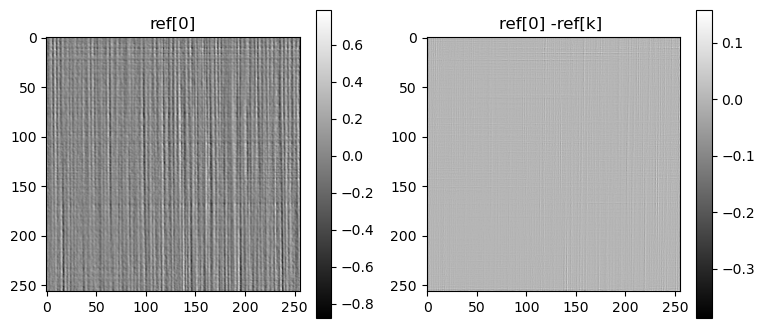

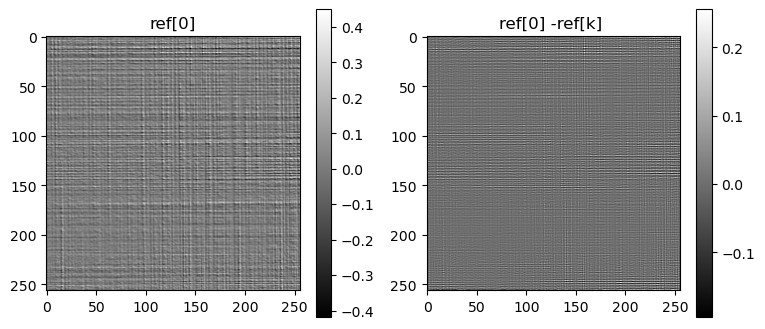

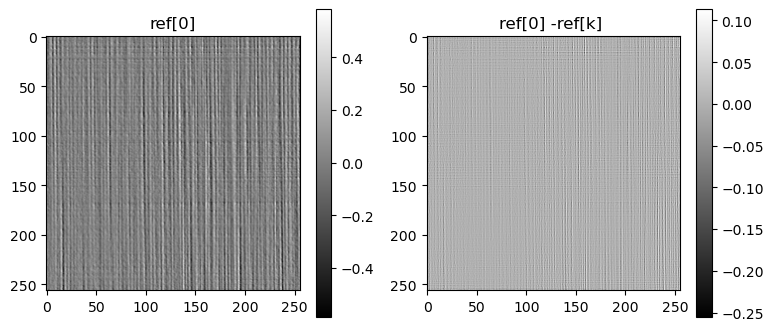

In [6]:
for k in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(ref00[0]-ref00[k],cmap='gray')
    axs[0].set_title('ref[0]-ref[k]')
    fig.colorbar(im)
    im=axs[1].imshow(ref0[0].get()-ref0[k].get(),cmap='gray')#,vmin=-500,vmax=500)
    axs[1].set_title('shifted ref[0]-ref[k] ')
    fig.colorbar(im)

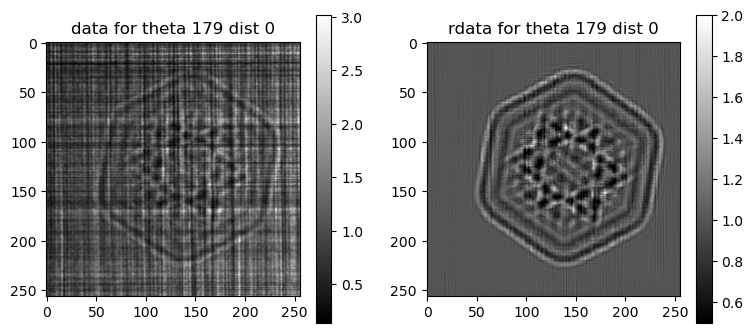

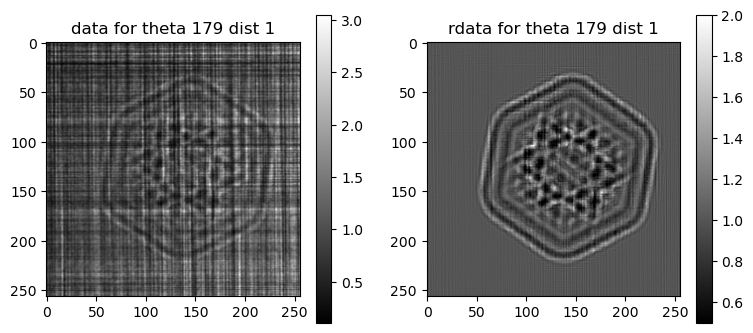

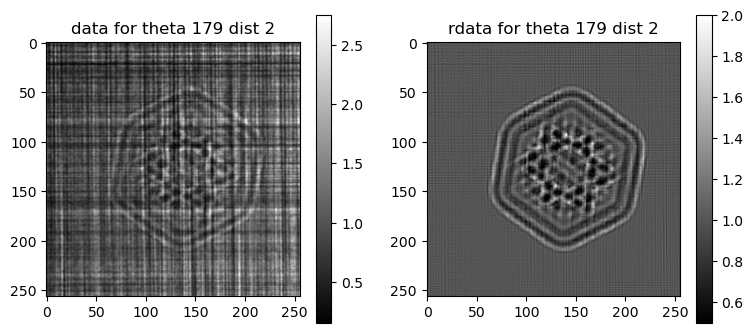

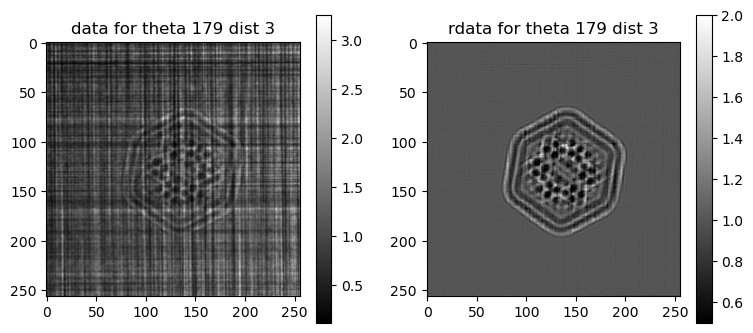

In [7]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(data0[k,-1].get(),cmap='gray')#,vmin = 0.5,vmax=2 )
    axs[0].set_title(f'data for theta {ntheta-1} dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata[k,-1].get(),cmap='gray',vmin = 0.5,vmax=2)
    axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
    fig.colorbar(im)

# Scale images and shift to the same position alogn the beam

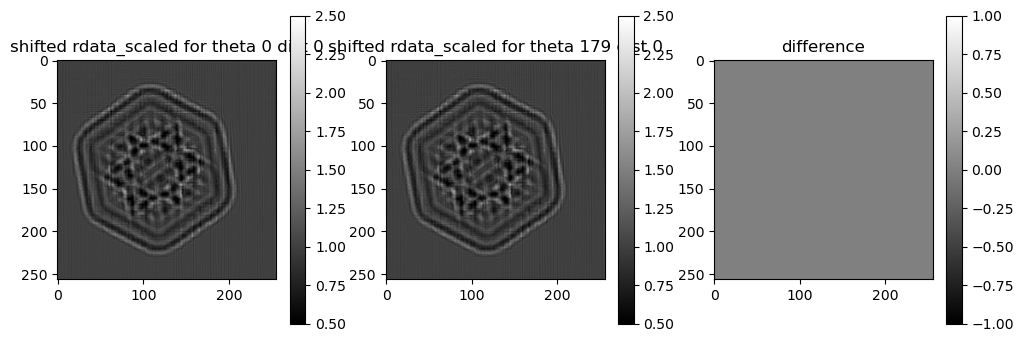

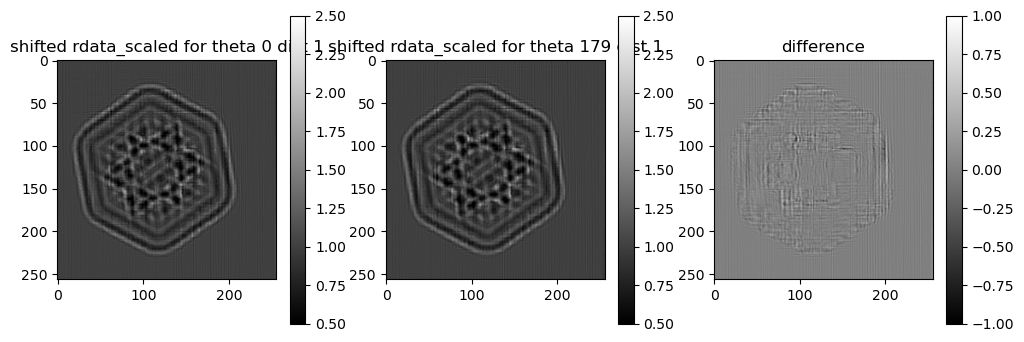

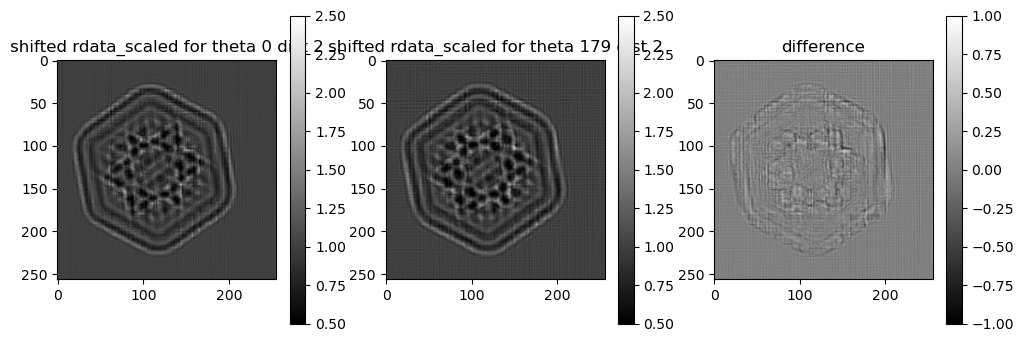

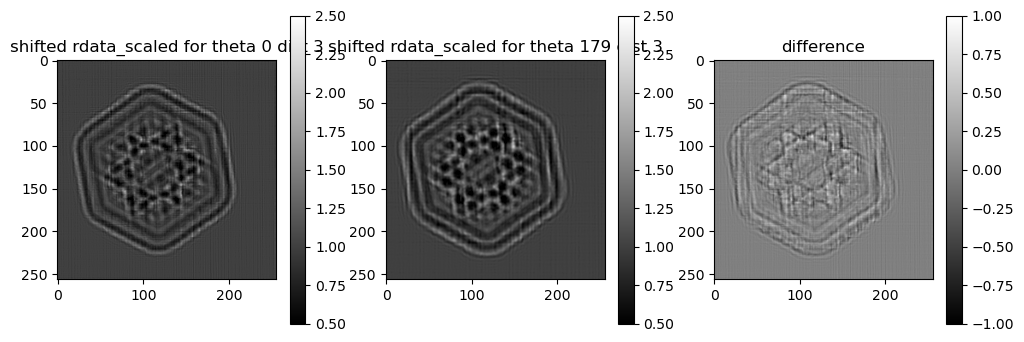

In [8]:
rdata_scaled = rdata.copy()

for k in range(ndist):  
    pars = {'magnification': 1/norm_magnifications[k], 'n':n}
    rdata_scaled[k] = M(rdata_scaled[k],pars).real
    pars = {'shift': shifts_sample[k]}
    rdata_scaled[k] = ST(rdata_scaled[k],pars).real

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im=axs[0].imshow(rdata_scaled[0,0].get(),cmap='gray',vmin = 0.5,vmax=2.5 )
    axs[0].set_title(f'shifted rdata_scaled for theta 0 dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata_scaled[k,0].get(),cmap='gray',vmin = 0.5,vmax=2.5 )
    axs[1].set_title(f'shifted rdata_scaled for theta {ntheta-1} dist {k}')
    fig.colorbar(im)        
    im=axs[2].imshow(rdata_scaled[0,0].get()-rdata_scaled[k,0].get(),cmap='gray',vmin =-1,vmax=1 )
    axs[2].set_title(f'difference')
    fig.colorbar(im)        

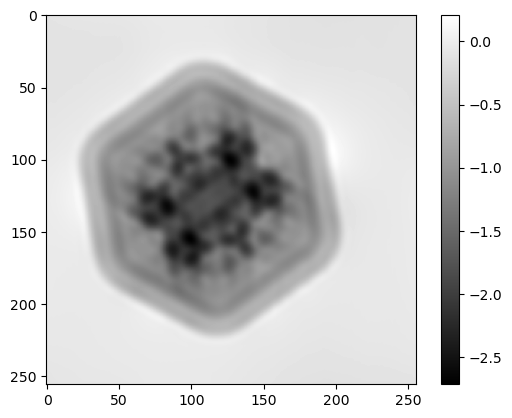

In [9]:
def multiPaganin(rads, wlen, dists, delta_beta, fx, fy, alpha):
    """
    Phase retrieval method based on Contrast Transfer Function. This 
    method relies on linearization of the direct problem, based  on  the
    first  order  Taylor expansion of the transmittance function.
    Found in Yu et al. 2018 and adapted from Cloetens et al. 1999


    Parameters
    ----------
    rad : 2D-array
        projection.
    wlen : float
        X-ray wavelentgth assumes monochromatic source.
    dist : float
        Object to detector distance (propagation distance) in mm.
    delta : float    
        refractive index decrement
    beta : float    
        absorption index
    fx, fy : ndarray
        Fourier conjugate / spatial frequency coordinates of x and y.
    alpha : float
        regularization factor.
        
    Return
    ------

    phase retrieved projection in real space
    """    
    numerator = 0
    denominator = 0    
    for j in range(0, len(dists)):    
        rad_freq = cp.fft.fft2(rads[j])    
        taylorExp = 1 + wlen * dists[j] * cp.pi * (delta_beta) * (fx**2+fy**2)
        numerator = numerator + taylorExp * (rad_freq)
        denominator = denominator + taylorExp**2 

    numerator = numerator / len(dists)
    denominator = (denominator / len(dists)) + alpha

    phase = cp.log(cp.real(  cp.fft.ifft2(numerator / denominator) ))    
    phase = (delta_beta) * 0.5 * phase

    
    return phase

distances_rec = (distances/norm_magnifications**2)[:ndist]

fx = cp.fft.fftfreq(n,d=voxelsize)
[fx,fy] = cp.meshgrid(fx,fx)

recMultiPaganin = cp.zeros([ntheta,n,n],dtype='complex64')
for k in range(ntheta):
    rads = rdata_scaled[:ndist,k]
    recMultiPaganin[k] = cp.exp(1j*multiPaganin(rads, wavelength, distances_rec, 100, fx, fy, 1e-12))
plt.imshow(cp.angle(recMultiPaganin[0]).get(),cmap='gray')
plt.colorbar()
dxchange.write_tiff(cp.angle(recMultiPaganin).get(),f'/data/vnikitin/modeling/rec/MultiPaganin.tiff',overwrite=True)



# Construct operators


### Forward holo: $d=\mathcal{G}_{z_j}\left((\mathcal{G}_{z_j'}\mathcal{S}_{s'_{j}}q)\mathcal{M}_j\mathcal{S}_{s_{j}}\psi\right)$

In [10]:
def fwd_holo(psi,prb):
    ''' Holography data modeling operator '''

    data = cp.zeros([ndist, ntheta, n, n], dtype='complex64')
    for j in range(ndist):        
        # ill shift for each acquisition
        pars = {'shift': shifts_ref[j]}        
        prbr = S(prb, pars)    
        
        # propagate illumination
        pars = {'wavelength': wavelength, 'z': distances2[j], 'voxelsize': voxelsize}
        prbr = G(prbr, pars)
        
        # object shift for each acquisition
        pars = {'shift': shifts_sample[j]/norm_magnifications[j]}        
        psir = S(psi, pars)            
        
        # scale object        
        if ne != n:
            pars = {'magnification': norm_magnifications[j]*ne/(n+2*pad), 'n': n+2*pad}
            psir = M(psir, pars)                
        
        # multiply the ill and object
        psir *= prbr

        # propagate both
        pars = {'wavelength': wavelength, 'z': distances[j], 'voxelsize': voxelsize}
        psir = G(psir, pars)   
        data[j] = psir[:,pad:n+pad,pad:n+pad]
    return data


### 
### Adjoint holo: $\psi=\sum_j\mathcal{S}^H_{s_j}\mathcal{M}_j^H\left((\mathcal{G}_{z_j'}\mathcal{S}_{s'_{j}}q)^*\mathcal{G}^H_{z_j}d\right)$


In [11]:
def adj_holo(data, prb):
    ''' Adjoint Holography operator '''

    psi = cp.zeros([ntheta, ne, ne], dtype='complex64')
    for j in range(ndist):
        psir = cp.pad(data[j].copy(),((0,0),(pad,pad),(pad,pad)))
        
        # propagate data back
        pars = {'wavelength': wavelength, 'z': distances[j], 'voxelsize': voxelsize}
        psir = GT(psir, pars)   
        
        # ill shift for each acquisition
        pars = {'shift': shifts_ref[j]}        
        prbr = S(prb, pars)    
        
        # propagate illumination
        pars = {'wavelength': wavelength, 'z': distances2[j], 'voxelsize': voxelsize}
        prbr = G(prbr, pars)
        
        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # scale object        
        if ne != n:
            pars = {'magnification': norm_magnifications[j]*ne/(n+2*pad), 'ne': ne}
            psir = MT(psir, pars) 
        # object shift for each acquisition
        pars = {'shift': shifts_sample[j]/norm_magnifications[j]}        
        psi += ST(psir, pars)  

    return psi


# Adjoint test

In [12]:
data = data0.copy()
ref = ref0.copy()
arr1 = cp.pad(cp.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')
prb1 = cp.pad(prb1,((0,0),(pad,pad),(pad,pad)))


arr2 = fwd_holo(arr1,prb1)
arr3 = adj_holo(arr2,prb1)
# plt.figure()
# plt.imshow(cp.real(arr2[0,0]).get())
# plt.colorbar()
# plt.figure()
# plt.imshow(cp.real(arr3[0]).get())
# plt.colorbar()

print(f'{cp.sum(arr1*np.conj(arr3))}==\n{cp.sum(arr2*np.conj(arr2))}')

(269606688+1637.064208984375j)==
(269606688+0.00019120144133921713j)


### Forward holo without sample: $d=\mathcal{G}_{z_j}\mathcal{S}_{s'_{j}}q$

In [13]:

def fwd_holo0(prb):
    ''' Holography operator without sample'''

    data = cp.zeros([ndist, n, n], dtype='complex64')
    for i in range(ndist):
        
        # ill shift for each acquisition
        pars = {'shift': shifts_ref0[i]}        
        prbr = S(prb, pars)             
        
        # propagate illumination 
        pars = {'wavelength': wavelength, 'z': distances[0], 'voxelsize': voxelsize}
        # prbr= prbr[:,pad:-pad,pad:-pad]
        
        data[i] = G(prbr, pars)[:,pad:n+pad,pad:n+pad]
    return data

### Adjoint holo without sample: $q=\sum_j\mathcal{S}^H_{s'_{j}}\mathcal{G}^H_{z_j}d$

In [14]:
def adj_holo0(data):
    ''' Adjoint Holography data operator without sample'''

    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(ndist):
        prbr = data[i:i+1].copy()
        prbr = cp.pad(prbr,((0,0),(pad,pad),(pad,pad)))        
        # propagate illumination 
        pars = {'wavelength': wavelength, 'z': distances[0], 'voxelsize': voxelsize}
        prbr = GT(prbr, pars)

        
        # ill shift for each acquisition
        pars = {'shift': shifts_ref0[i]}        
        prbr = ST(prbr, pars)          
        prb += prbr     
    return prb

In [15]:
data = data0[:,0].copy()
ref = ref0.copy()
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')
prb1 = cp.pad(prb1,((0,0),(pad,pad),(pad,pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)

print(f'{cp.sum(prb1*np.conj(arr3))}==\n{cp.sum(arr2*np.conj(arr2))}')


(593278.875-0.01401200145483017j)==
(593278.875+2.1800194645038573e-06j)


### 
### Adjoint holo wrt probe: $q=\sum_{j,k}\mathcal{S}_{s_{k,j}'}\mathcal{G}_{z_j'}^H\left((\mathcal{M}_j\mathcal{S}_{s_{k,j}}\psi_k)^*\mathcal{G}^H_{z_j}d\right)$


In [16]:
def adj_holo_prb(data, psi):
    ''' Adjoint Holography operator '''

    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(ndist):
        prbr = cp.pad(data[j].copy(),((0,0),(pad,pad),(pad,pad)))
        psir = psi.copy()
        
        # propagate data back
        pars = {'wavelength': wavelength, 'z': distances[j], 'voxelsize': voxelsize}
        prbr = GT(prbr, pars)   
        

        # object shift for each acquisition
        pars = {'shift': shifts_sample[j]/norm_magnifications[j]}        
        psir = S(psir, pars)            
        
        # scale object        
        pars = {'magnification': norm_magnifications[j]*ne/(n+2*pad), 'n': n+2*pad}
        psir = M(psir, pars)                
        
        # multiply the conj object and ill
        prbr *= cp.conj(psir)
        
        # propagate illumination
        pars = {'wavelength': wavelength, 'z': distances2[j], 'voxelsize': voxelsize}
        prbr = GT(prbr, pars)

        # ill shift for each acquisition
        pars = {'shift': shifts_ref[j]}        
        prbr = ST(prbr, pars)    

        prb += cp.sum(prbr,axis=0)
    return prb

# Adjoint test

In [17]:
data = data0.copy()
ref = ref0.copy()
arr1 = cp.pad(cp.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')
prb1 = cp.pad(prb1,((0,0),(pad,pad),(pad,pad)))
arr2 = fwd_holo(arr1,prb1)
arr3 = adj_holo_prb(arr2,arr1)

print(f'{cp.sum(prb1*np.conj(arr3))}==\n{cp.sum(arr2*np.conj(arr2))}')

(269606720-7.6474609375j)==
(269606688+0.00035606318851932883j)


0) gammaprb=0.5, err=5.85602e+03


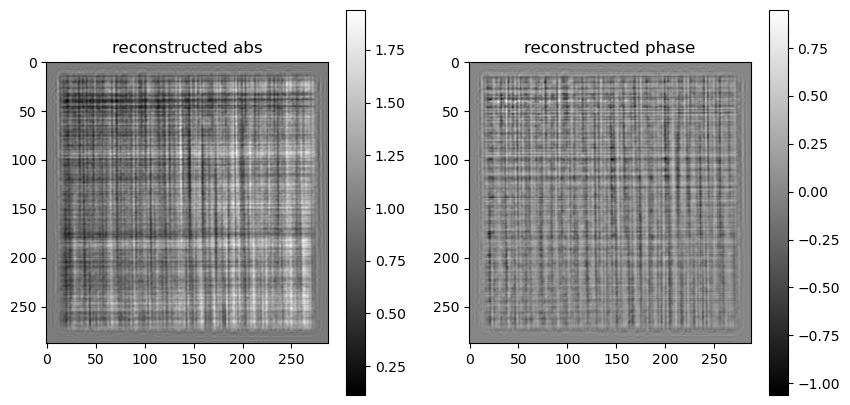

1) gammaprb=0.5, err=4.95482e+02
2) gammaprb=0.5, err=4.28858e+02
3) gammaprb=0.5, err=3.90801e+02
4) gammaprb=0.5, err=3.82718e+02


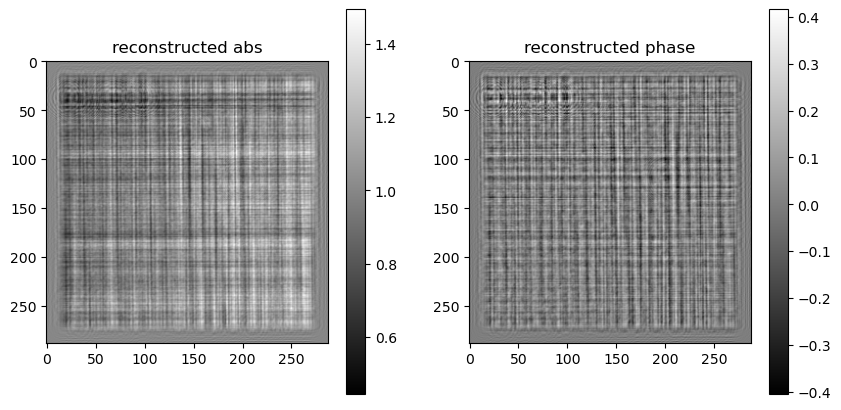

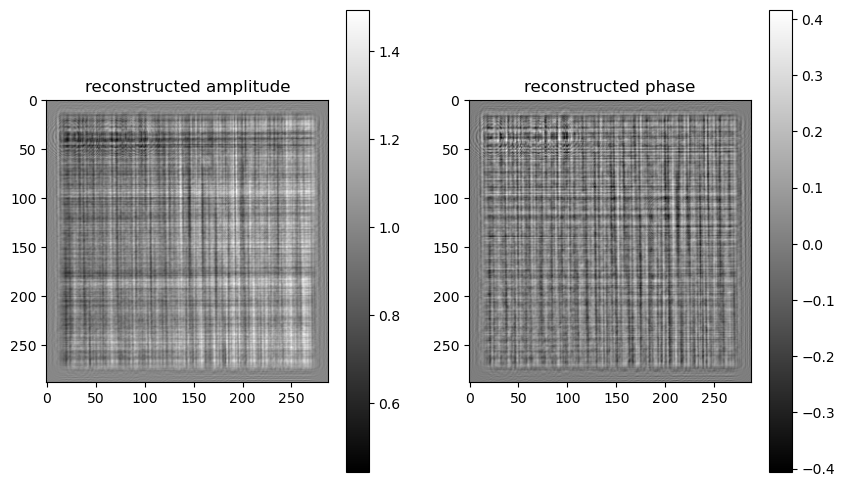

In [18]:

def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo(ref, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fprb):
        f = np.linalg.norm(np.abs(fprb)-ref)**2        
        return f        
    
    ref = cp.sqrt(ref)
    prb = init_prb.copy()

    for i in range(pars['niter']):
        fprb0 = fwd_holo0(prb)
        gradprb = adj_holo0(fprb0-ref*cp.exp(1j*cp.angle(fprb0)))
        
        if i == 0:
            dprb = -gradprb
        else:
            dprb = -gradprb+cp.linalg.norm(gradprb)**2 / \
                ((cp.sum(cp.conj(dprb)*(gradprb-gradprb0))))*dprb
        gradprb0 = gradprb
        
        # line search
        fdprb0 = fwd_holo0(dprb)
        
        gammaprb = line_search(minf,pars['gammaprb'], fprb0, fdprb0)
        prb = prb + gammaprb*dprb
        
        if i%pars['err_step']==0:
            fprb0 = fwd_holo0(prb) 
            err = minf(fprb0)
            print(f'{i}) {gammaprb=}, {err=:1.5e}')  
            
        
        if i%pars['vis_step']==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.abs(prb[0]).get(),cmap='gray')
            axs[0].set_title('reconstructed abs')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(prb[0]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase')
            fig.colorbar(im)                
            plt.show()                        
            
    return prb

rec_prb0 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64') 

pars = {'niter': 5, 'err_step': 1, 'vis_step': 4, 'gammaprb': 0.5}
rec_prb0 = cg_holo(ref, rec_prb0, pars)


fig, axs = plt.subplots(1, 2, figsize=(10, 6))
im=axs[0].imshow(cp.abs(rec_prb0[0]).get(),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(cp.angle(rec_prb0[0]).get(),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)


#### $\ \sum_k\sum_j||\mathcal{G}_{z_j}((\mathcal{G}_{z'_j}q)(M_j S_{s_{kj}}\psi_k))|-\sqrt{d_{kj}}\|^2_2 + \||\mathcal{G}_{z_0}q|-\sqrt{d^r}\|_2^2\to \text{min}_{\psi_k,q}$ 

0) gammapsi=0.5 gammaprb=0.5, err=1.98252e+04


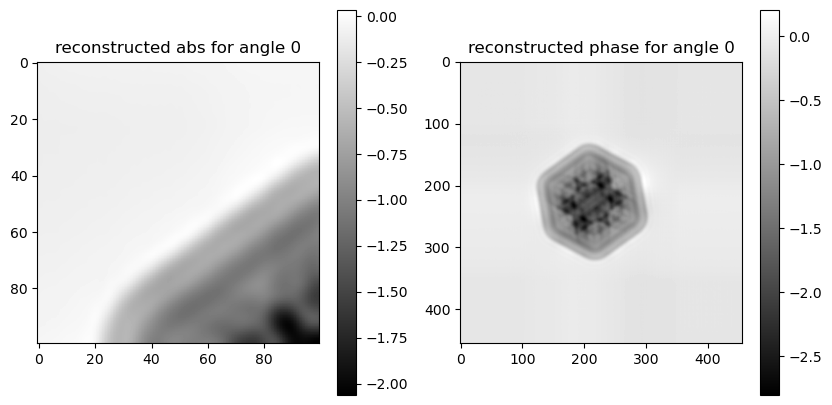

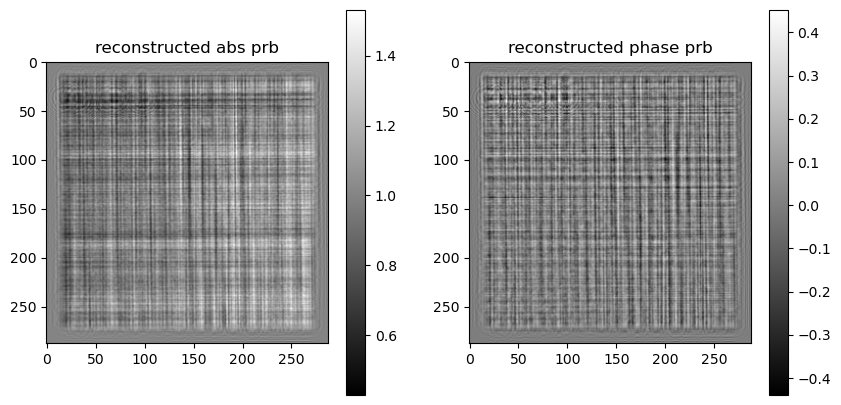

4) gammapsi=0.5 gammaprb=0.5, err=4.53574e+03


In [19]:

def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma >= 1/64):
        gamma *= 0.5
    if(gamma < 1/64):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_holo(data, ref, init, init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional

    def minf(fpsi,fprb):
        f = np.linalg.norm(cp.abs(fpsi)-data)**2            
        if isinstance(fprb,cp.ndarray):
            f += np.linalg.norm(np.abs(fprb)-ref)**2        
        return f      
      
    data = cp.sqrt(data)
    ref = cp.sqrt(ref)
    psi = init.copy()
    prb = init_prb.copy()
    conv = np.zeros(pars['niter'])
    for i in range(pars['niter']):
        if pars['upd_psi']:
            
            fpsi = fwd_holo(psi,prb)          
            grad = adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb)/cp.max(cp.abs(prb))**2
            
            #d = -grad
            # Dai-Yuan direction
            if i == 0:
                d = -grad
            else:
                d = -grad+cp.linalg.norm(grad)**2 / \
                    ((cp.sum(cp.conj(d)*(grad-grad0))))*d
            grad0 = grad
            fd = fwd_holo(d, prb)     
            gammapsi = line_search(minf,pars['gammapsi'], fpsi, 0, fd, 0)
      
            psi = psi+gammapsi*d
            
        if pars['upd_prb']:
            fprb = fwd_holo(psi,prb)
            fprb0 = fwd_holo0(prb)
            gradprb = adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi)
            gradprb += adj_holo0(fprb0-ref*cp.exp(1j*cp.angle(fprb0)))
            gradprb*=1/(ntheta+1)
            
            #dprb = -gradprb
             # Dai-Yuan direction
            if i == 0:
                dprb = -gradprb
            else:
                dprb = -gradprb+cp.linalg.norm(gradprb)**2 / \
                    ((cp.sum(cp.conj(dprb)*(gradprb-gradprb0))))*dprb
            gradprb0 = gradprb
            
            # line search
            fdprb = fwd_holo(psi, dprb)
            fdprb0 = fwd_holo0(dprb)
            
            gammaprb = line_search(minf,pars['gammaprb'], fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%pars['err_step']==0:
            fprb = fwd_holo(psi,prb)
            fprb0 = fwd_holo0(prb) 
            err = minf(fprb,fprb0)
            conv[i] =err
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')  
            
        
        if i%pars['vis_step']==0:  
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            #im=axs[0].imshow(cp.abs(psi[0]).get(),cmap='gray')
            im=axs[0].imshow(cp.angle(rec[0,100:200,100:200]).get(),cmap='gray')
            axs[0].set_title('reconstructed abs for angle 0')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(psi[0]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase for angle 0')
            fig.colorbar(im)                
            plt.show()
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            im=axs[0].imshow(cp.abs(prb[0]).get(),cmap='gray')
            axs[0].set_title('reconstructed abs prb')
            fig.colorbar(im)
            im=axs[1].imshow(cp.angle(prb[0]).get(),cmap='gray')
            axs[1].set_title('reconstructed phase prb')
            fig.colorbar(im)                
            plt.show()
            # fig, axs = plt.subplots(1, 3, figsize=(10, 3))
            # im=axs[0].imshow(cp.abs(fpsi[0,0]).get(),cmap='gray')
            # axs[0].set_title('fpsi**2')
            # fig.colorbar(im)
            # im=axs[1].imshow(cp.abs(data[0,0]).get(),cmap='gray')
            # axs[1].set_title('data')
            # fig.colorbar(im)          
            # im=axs[2].imshow(cp.abs(data[0,0]).get()-cp.abs(fpsi[0,0]).get(),cmap='gray')
            # axs[2].set_title('err')
            # fig.colorbar(im)        
            # plt.show()
            # dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/modeling/r_{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.abs(psi).get(),f'/data/vnikitin/modeling/rabs_{n}_{ntheta}_{ndist}/r{i:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/modeling/r_{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.abs(prb[0]).get(),f'/data/vnikitin/holo/3d_ald_syn/pabs_{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)
            # dxchange.write_tiff(cp.angle(prb[0]).get(),f'/data/vnikitin/modeling/3d_ald_syn/pangle_{n}_{ntheta}_{ndist}/o{i:05}.tiff',overwrite=True)            
            
            
    return psi,prb,conv

rec = cp.pad(recMultiPaganin, ((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')# cp.ones([ntheta,ne,ne],dtype='complex64')
rec_prb = rec_prb0.copy()#cp.ones([1,n,n],dtype='complex64')        
pars = {'niter': 2049, 'upd_psi': True, 'upd_prb': True, 'err_step': 4, 'vis_step': 128, 'gammapsi': 0.5, 'gammaprb':0.5}
rec,rec_prb,conv = cg_holo(data,ref,rec,rec_prb,pars)

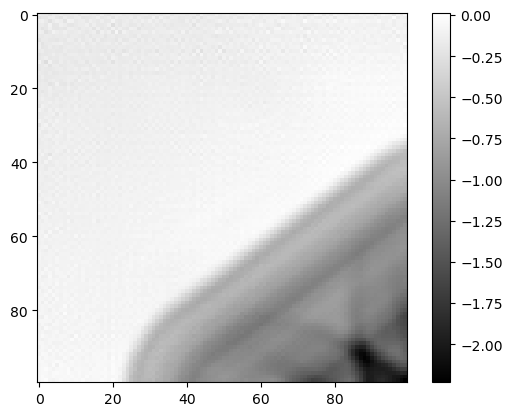

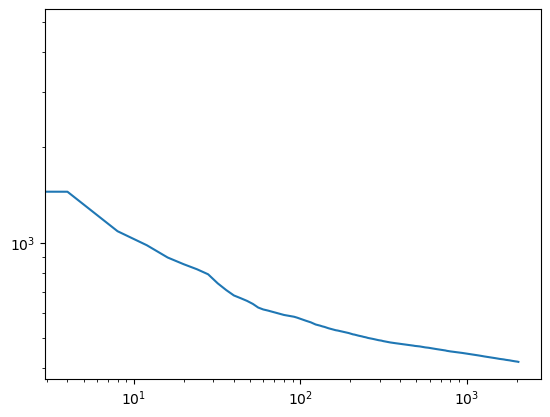

In [ ]:
plt.imshow(cp.angle(rec[0,100:200,100:200]).get(),cmap='gray')
plt.colorbar()

plt.show()
plt.loglog(np.arange(0,pars['niter'],4),conv[::4])


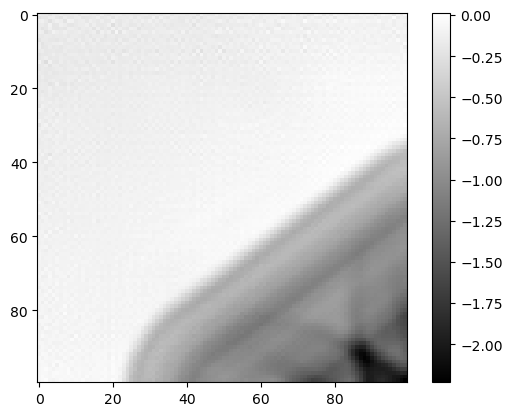

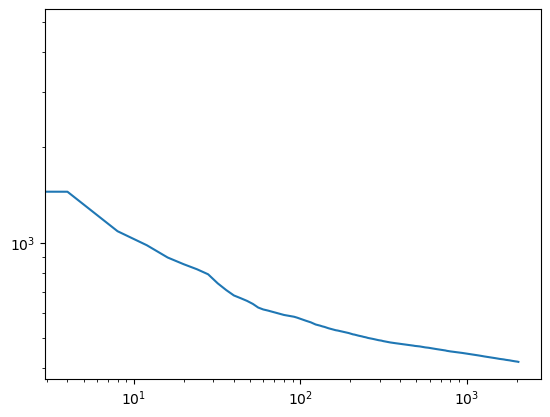

In [ ]:
plt.imshow(cp.angle(rec[0,100:200,100:200]).get(),cmap='gray')
plt.colorbar()

plt.show()
plt.loglog(np.arange(0,pars['niter'],4),conv[::4])
